In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import os
import numpy as np
import keras.backend as K
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = ""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


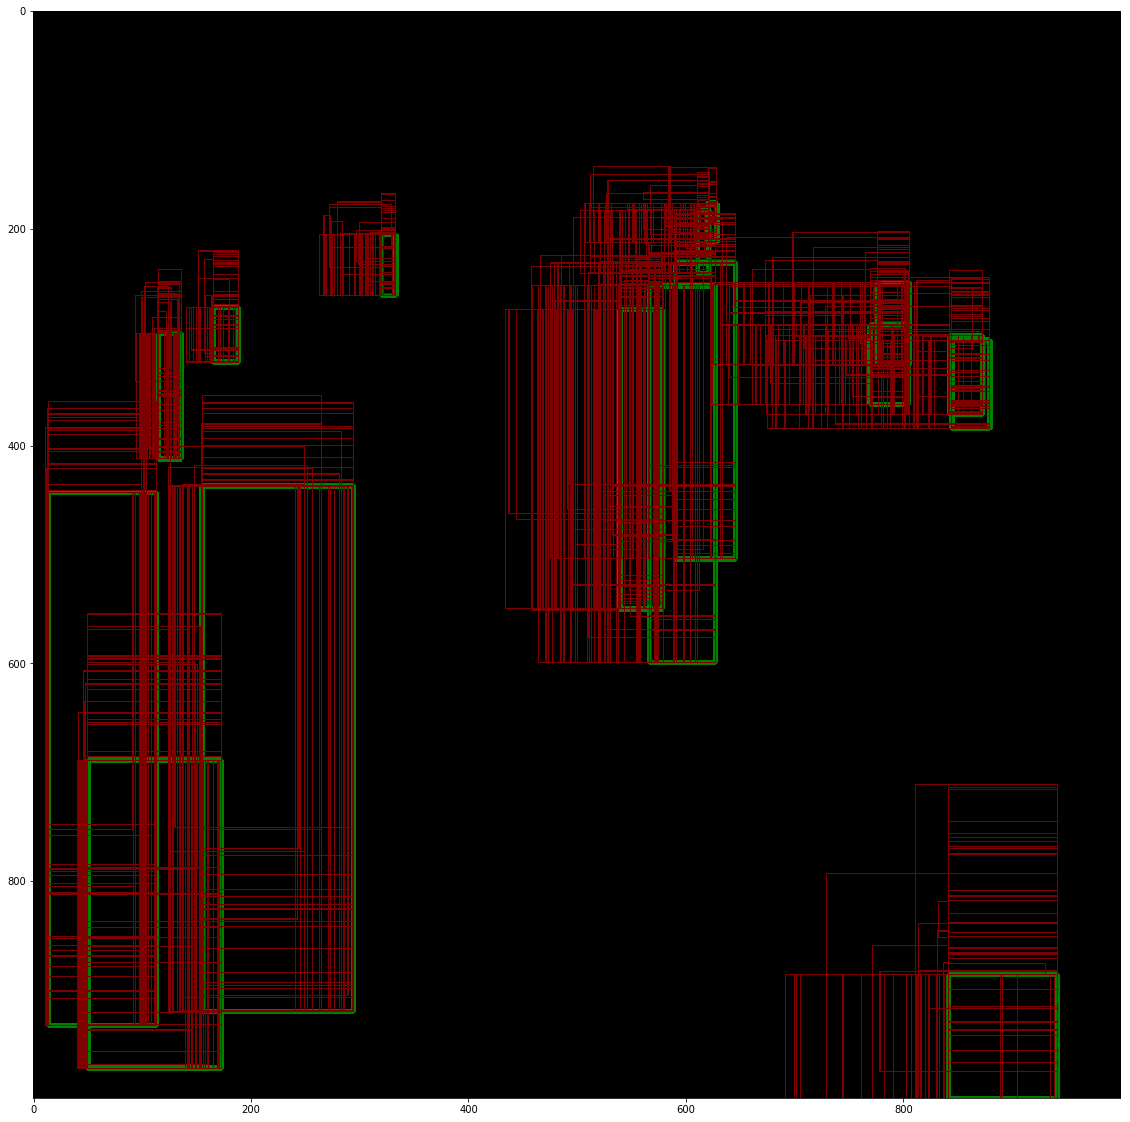

In [301]:
from utils import *

y_true, y_pred = get_boxes(similarity=0.8)
draw_boxes(y_true, y_pred)

y_true = np.expand_dims(y_true, axis=0)[..., :4]
y_pred = np.expand_dims(y_pred, axis=0)[..., :4]
y_pred = np.concatenate([y_pred, np.random.sample((y_pred.shape[0], y_pred.shape[1], 1))], axis=2)

In [296]:
def bbox_overlap_iou(bboxes1, bboxes2):
    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=2)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=2)
    x11 = np.transpose(x11, (1, 2, 0))
    y11 = np.transpose(y11, (1, 2, 0))
    x12 = np.transpose(x12, (1, 2, 0))
    y12 = np.transpose(y12, (1, 2, 0))

    x21 = np.transpose(x21, (1, 2, 0))
    y21 = np.transpose(y21, (1, 2, 0))
    x22 = np.transpose(x22, (1, 2, 0))
    y22 = np.transpose(y22, (1, 2, 0))

    xI1 = np.maximum(x11, np.transpose(x21))
    yI1 = np.maximum(y11, np.transpose(y21))

    xI2 = np.minimum(x12, np.transpose(x22))
    yI2 = np.minimum(y12, np.transpose(y22))

    inter_area = (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    bboxes1_area = (x12 - x11 + 1) * (y12 - y11 + 1)
    bboxes2_area = (x22 - x21 + 1) * (y22 - y21 + 1)

    union = (bboxes1_area + np.transpose(bboxes2_area)) - inter_area

    return np.transpose(np.maximum(inter_area / union, 0), (1, 0, 2)) 


def smooth_l1_distance(y_true, y_pred, delta=0.5):
    sigma_squared = delta ** 2

    regression_diff = y_pred - y_true

    regression_diff = np.abs(regression_diff)
    
    return np.where(regression_diff < (1.0 / sigma_squared),
                    0.5 * sigma_squared * np.power(regression_diff, 2),
                    regression_diff - 0.5 / sigma_squared)


def test_attraction_numpy(y_true, y_pred):
    iou_over_gt = bbox_overlap_iou(y_true, y_pred)
    
    len_of_batch = y_true.shape[0]
    len_of_gt = y_true.shape[1]
    len_of_pd = y_pred.shape[1]

    a = np.zeros((len_of_batch, len_of_gt, len_of_pd, 5))
    a[..., 0] = iou_over_gt
    a[..., 1:] = y_pred
    
    maxes = np.argmax(a[..., 0], axis=2)    
    pred_boxes_with_max_ious = a[([0] * len_of_batch, range(len_of_gt), maxes[0])][..., 1:]
    return np.sum(smooth_l1_distance(y_true, pred_boxes_with_max_ious)) / np.shape(y_true)[1]

test_attraction(y_true, y_pred)

ValueError: array split does not result in an equal division

In [312]:
def bbox_overlap_iou(bboxes1, bboxes2):
    x11, y11, x12, y12 = tf.split(bboxes1, 4, axis=2)
    x21, y21, x22, y22 = tf.split(bboxes2, 4, axis=2)

    x11 = tf.transpose(x11, (1, 2, 0))
    y11 = tf.transpose(y11, (1, 2, 0))
    x12 = tf.transpose(x12, (1, 2, 0))
    y12 = tf.transpose(y12, (1, 2, 0))

    x21 = tf.transpose(x21, (1, 2, 0))
    y21 = tf.transpose(y21, (1, 2, 0))
    x22 = tf.transpose(x22, (1, 2, 0))
    y22 = tf.transpose(y22, (1, 2, 0))

    xI1 = tf.maximum(x11, tf.transpose(x21))
    yI1 = tf.maximum(y11, tf.transpose(y21))

    xI2 = tf.minimum(x12, tf.transpose(x22))
    yI2 = tf.minimum(y12, tf.transpose(y22))

    inter_area = (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    bboxes1_area = (x12 - x11 + 1) * (y12 - y11 + 1)
    bboxes2_area = (x22 - x21 + 1) * (y22 - y21 + 1)

    union = (bboxes1_area + tf.transpose(bboxes2_area)) - inter_area

    return tf.transpose(tf.maximum(inter_area / union, 0.0), (1, 0, 2))


def bbox_iog(ground_truth, predicted):
    x11, y11, x12, y12 = tf.split(predicted, 4, axis=2)
    x21, y21, x22, y22 = tf.split(ground_truth, 4, axis=2)

    xI1 = tf.maximum(x11, tf.transpose(x21))
    yI1 = tf.maximum(y11, tf.transpose(y21))

    xI2 = tf.minimum(x12, tf.transpose(x22))
    yI2 = tf.minimum(y12, tf.transpose(y22))

    intersect_area = (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    gt_area = (x22 - x21 + 1) * (y22 - y21 + 1)

    return tf.transpose(tf.maximum(intersect_area / gt_area, 0.0), (1, 0, 2))


def smooth_l1_distance(y_true, y_pred, delta=0.5):
    sigma_squared = delta ** 2
    regression_diff = y_pred - y_true
    regression_diff = tf.abs(regression_diff)
    return tf.where(
        tf.less(regression_diff, 1.0 / sigma_squared),
        0.5 * sigma_squared * K.pow(regression_diff, 2),
        regression_diff - 0.5 / sigma_squared
    )


def smooth_ln(x, delta):
    return tf.where(
        tf.less_equal(x, delta),
        -tf.log(1 - x),
        ((x - delta) / (1 - delta)) - tf.log(1 - delta)
    )


def attraction_term(y_true, y_pred, ious_over_truth_boxes):
    # Найти из y_true бокс с большим IOU для всех y_pred
    # Прогоняем его через smooth_l1
    # Суммиируем
    # Делим на количество y_pred

    iou_max_indices = tf.argmax(ious_over_truth_boxes[..., 0], axis=2)
    ious_over_truth_boxes = ious_over_truth_boxes[..., 1:]

    pred_boxes_with_max_ious = None
    for batch_num in np.arange(y_pred.shape[0].value, dtype=np.int64):
        indices = tf.stack([tf.cast(tf.tile([batch_num], [tf.shape(y_true)[1]]), dtype=tf.int64),
                            tf.range(tf.cast(tf.shape(y_true)[1], dtype=tf.int64)),
                            tf.cast(iou_max_indices[batch_num], dtype=tf.int64)])
        indices = tf.transpose(indices)

        if pred_boxes_with_max_ious is None:
            pred_boxes_with_max_ious = tf.expand_dims(tf.gather_nd(ious_over_truth_boxes, indices), axis=0)
        else:
            boxes_with_max_ious = tf.expand_dims(tf.gather_nd(ious_over_truth_boxes, indices), axis=0)
            pred_boxes_with_max_ious = tf.concat([pred_boxes_with_max_ious, boxes_with_max_ious], axis=0)

    l1_distances = smooth_l1_distance(y_true, pred_boxes_with_max_ious)
    return tf.reduce_sum(tf.cast(l1_distances, tf.float32)) / tf.cast(tf.shape(y_true)[1], dtype=tf.float32)


def repulsion_term_gt(y_true, y_pred, ious_over_truth_boxes, alpha):
    # Найти из y_true бокс с вторым по величине IOU
    # Находим IoG между этим боксом и y_true
    # Прогоняем IoG через smooth_ln
    # Суммиируем
    # Делим на количество y_pred

    alpha = tf.Variable(alpha, dtype=tf.float32)

    _, indices_2highest_iou = K.tf.nn.top_k(ious_over_truth_boxes[..., 0], k=2)
    ious_over_truth_boxes = ious_over_truth_boxes[..., 1:]
    indices_2highest_iou = indices_2highest_iou[..., 1]

    pred_boxes_with_max_ious = None
    for batch_num in np.arange(y_pred.shape[0].value, dtype=np.int64):
        indices = tf.stack([tf.cast(tf.tile([batch_num], [tf.shape(y_true)[1]]), dtype=tf.int64),
                            tf.range(tf.cast(tf.shape(y_true)[1], dtype=tf.int64)),
                            tf.cast(indices_2highest_iou[batch_num], dtype=tf.int64)])
        indices = tf.transpose(indices)

        if pred_boxes_with_max_ious is None:
            pred_boxes_with_max_ious = tf.expand_dims(tf.gather_nd(ious_over_truth_boxes, indices), axis=0)
        else:
            boxes_with_max_ious = tf.expand_dims(tf.gather_nd(ious_over_truth_boxes, indices), axis=0)
            pred_boxes_with_max_ious = tf.concat([pred_boxes_with_max_ious, boxes_with_max_ious], axis=0)

    ln_distances_for_iog = smooth_ln(bbox_iog(y_true, pred_boxes_with_max_ious), alpha)
    return tf.reduce_sum(ln_distances_for_iog) / tf.cast(tf.shape(y_true)[1], dtype=tf.float32)


def repulsion_term_box(y_pred, betta):
    # Делим все множество y_pred боксов на бокс + цель (Проходимся циклом и оставляем для каждой y_true бокс из y_pred с наибольшим IoU)
    # Находим IoU для каждой пары сочетания (Bi, Bj)
    # Для каждой пары находим отношение smooth_ln(IoU) / IoU + e
    # Суммиируем

    iou_over_predicted = bbox_overlap_iou(y_pred, y_pred)
    iou_over_predicted_indices = tf.where(tf.less(iou_over_predicted, 1.0))
    iou_over_predicted = tf.gather_nd(iou_over_predicted, iou_over_predicted_indices)

    dist_sum = tf.reduce_sum(smooth_ln(iou_over_predicted, betta))
    iou_sum = tf.reduce_sum(iou_over_predicted)

    return dist_sum / tf.maximum(iou_sum, 0.000001)


def create_repulsion_loss(alpha=0.5, betta=0.5):
    def _filter_predictions(y_pred):
        y_pred_indices = tf.where(tf.greater_equal(y_pred[..., 4], 0.5))
        return tf.gather_nd(y_pred, [y_pred_indices])

    def _preprocess_inputs(y_true, y_pred):
        return y_true[..., :4], y_pred[..., :4]

    def _repulsion_impl(y_true, y_pred):
        len_of_gt = tf.shape(y_true)[1]

        iou_over_gt = bbox_overlap_iou(y_true, y_pred)
        tiled_for_concat = tf.tile(tf.expand_dims(y_pred, axis=1), [1, len_of_gt, 1, 1])
        highest_iou = tf.concat([tf.expand_dims(iou_over_gt, axis=3), tiled_for_concat], axis=3)

        return tf.reduce_sum([
            attraction_term(y_true, y_pred, highest_iou),
            repulsion_term_gt(y_true, y_pred, highest_iou, alpha),
            repulsion_term_box(y_pred, betta)
        ])

    def _repulsion_loss(y_true, y_pred):
        # Фильтруем y_pred, оставляя те, у которых IOU > 0,5 хотябы с одним y_true

        y_pred = _filter_predictions(y_pred)
        y_true, y_pred = _preprocess_inputs(y_true, y_pred)

        return tf.cond(tf.logical_or(tf.equal(tf.shape(y_pred)[1], 0), tf.equal(tf.shape(y_true)[1], 0)),
                       lambda: tf.Variable(0.0, dtype=tf.float32),
                       lambda: _repulsion_impl(y_true, y_pred))

    return _repulsion_loss

In [313]:
y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)

repulsion_loss = create_repulsion_loss()

g = tf.gradients(repulsion_loss(y_true_tensor, y_pred_tensor),
                 [y_true_tensor, y_pred_tensor])

%time print('repulsion_loss: ', K.eval(repulsion_loss(y_true_tensor, y_pred_tensor)))

repulsion_loss:  3.125383
CPU times: user 2.19 s, sys: 60.7 ms, total: 2.25 s
Wall time: 2.17 s
